## RPC- Classification

In [514]:
import splitfolders
import os
import torch,torchvision
from torch.utils.data import DataLoader
from torchvision.transforms import v2




#### Dataset loading and preprocessing

In [515]:
# file_name = "new_dataset"

# # Splitting folders
# splitfolders.ratio(file_name,seed=1337, ratio=(0.8,0.2))

train_path = "./output/train"
test_path = "./output/val"

In [516]:
transform = v2.Compose(
    [
        v2.Resize((128, 128)),
        # v2.Grayscale(num_output_channels=3),
        v2.ColorJitter(brightness=0.3,contrast=0.2,saturation=0.3,hue=0.05),
        v2.RandomPerspective(distortion_scale=0.2,p=0.3),
        v2.RandomRotation(degrees=(-180, 180), fill=255),
        v2.RandomHorizontalFlip(p=0.5),
        v2.RandomVerticalFlip(p=0.5),
        v2.ToTensor(),
        # v2.Lambda(lambda x: (x > 0.7).float()),
        v2.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5]),
    ]
)

/home/bititude/anaconda3/lib/python3.13/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [517]:
test_transform = v2.Compose(
  
    [
        v2.Lambda(lambda img: img.convert('RGB')),
        v2.Resize((128, 128)),
        # v2.Grayscale(num_output_channels=3),
        v2.ToTensor(),
        # v2.GaussianBlur(kernel_size=3),
        v2.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
        # v2.Lambda(lambda x: (x>0.9).float())
    ]
)

In [518]:
# preparing data for training

train_dataset = torchvision.datasets.ImageFolder(root=train_path,transform=transform)
test_dataset = torchvision.datasets.ImageFolder(root=test_path,transform=transform)


train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [519]:
class_names = train_dataset.classes
class_names

['paper', 'rock', 'scissors']

In [520]:
img,label=train_dataset[1234]

In [521]:
img.size()

torch.Size([3, 128, 128])

#### Define model and training

In [522]:
import torch.nn as nn
from torch.nn import MaxPool2d, Conv2d, Dropout ,Linear
import torch.nn.functional as F
import torch.optim as optim

In [523]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.cnv1 = Conv2d(3,16,3)  # (62,62)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = MaxPool2d(2,2) #(31,31)
        self.cnv2 = Conv2d(16,32,5) #(27,27)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = MaxPool2d(3,3) #(9,9) 

        # -> flatten  (32*9*9)

        self.fc1 = Linear(11552,64)
        self.fc2 = Linear(64,128)
        self.fc3 = Linear(128,64)
        self.fc4 = Linear(64,32) 
        self.fc5 = Linear(32,3)

        self.drop1 = Dropout(p=0.3)

    def forward(self,x):

        x = self.pool1(F.relu(self.bn1(self.cnv1(x))))
        x = self.pool2(F.relu(self.bn2(self.cnv2(x))))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.drop1(x)
        x = F.relu(self.fc2(x))
        x = self.drop1(x)
        x = F.relu(self.fc3(x))
        x = self.drop1(x)
        x = F.relu(self.fc4(x))
        x = self.fc5(x)

        return x

In [533]:
model = Model()

loss_function = nn.CrossEntropyLoss()

optimizer = optim.AdamW(model.parameters(),lr=0.001,weight_decay=0.001)



In [525]:
for epoch in range(50):

  running_loss = 0.0
  correct = 0
  total = 0

  train_accuracy, test_accuracy = 0,0

  model.train()  #setting model to train mode
  for input,label in train_loader:
    
    optimizer.zero_grad()
    output = model(input)
    
    loss = loss_function(output,label)

    loss.backward()
    optimizer.step()

    running_loss += loss.item()

    #accuracy calculation on train dataset
    _,predicted = torch.max(output,1)
    total += label.size(0)
    correct += (predicted == label).sum().item()

    train_accuracy = 100*correct/total

  correct = 0
  total = 0

  # accuracy calculation on test dataset
  model.eval()
  with torch.no_grad():
    for input,label in test_loader:
      
      output = model(input)
      _,predicted = torch.max(output,1)
      total += label.size(0)
      correct += (predicted == label).sum().item()

    test_accuracy = 100*correct/total

  
  
  print(f"Epoch: {epoch+1} | loss: {loss:.4f} | train acc: {train_accuracy:.2f} | test acc: {test_accuracy:.2f}")


Epoch: 1 | loss: 1.0706 | train acc: 38.49 | test acc: 44.82
Epoch: 2 | loss: 0.8880 | train acc: 46.24 | test acc: 43.58
Epoch: 3 | loss: 1.0406 | train acc: 48.86 | test acc: 42.86
Epoch: 4 | loss: 0.7758 | train acc: 52.23 | test acc: 55.49
Epoch: 5 | loss: 0.8901 | train acc: 51.45 | test acc: 56.83
Epoch: 6 | loss: 0.8429 | train acc: 53.83 | test acc: 57.04
Epoch: 7 | loss: 0.8733 | train acc: 57.03 | test acc: 57.97
Epoch: 8 | loss: 0.9054 | train acc: 58.24 | test acc: 65.84
Epoch: 9 | loss: 0.7696 | train acc: 63.02 | test acc: 68.63
Epoch: 10 | loss: 0.7740 | train acc: 63.48 | test acc: 72.15
Epoch: 11 | loss: 0.6588 | train acc: 65.90 | test acc: 78.88
Epoch: 12 | loss: 0.7321 | train acc: 69.17 | test acc: 67.39
Epoch: 13 | loss: 0.9050 | train acc: 69.53 | test acc: 77.23
Epoch: 14 | loss: 0.5961 | train acc: 72.35 | test acc: 76.19
Epoch: 15 | loss: 0.6663 | train acc: 72.42 | test acc: 78.47
Epoch: 16 | loss: 0.7817 | train acc: 75.08 | test acc: 86.13
Epoch: 17 | loss:

In [526]:
correct = 0
total = 0

model.eval()

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total * 100

print(f"Accuracy: {accuracy:.2f}")

Accuracy: 95.45


In [527]:
#Saving model

# torch.save(model.state_dict(),'94acc_mixdataset_almost.pth')

### -> Loading previous model which works better for unsean data

In [537]:
class Model(nn.Module):

    def __init__(self):
        super().__init__()

        self.cnv1 = Conv2d(3, 16, 3)  # (62,62)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = MaxPool2d(2, 2)  # (31,31)
        self.cnv2 = Conv2d(16, 32, 5)  # (27,27)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = MaxPool2d(3, 3)  # (9,9)

        # -> flatten  (32*9*9)

        self.fc1 = Linear(11552, 64)
        self.fc2 = Linear(64, 128)
        self.fc3 = Linear(128, 256)
        self.fc4 = Linear(256, 64)
        self.fc5 = Linear(64, 3)

        self.drop1 = Dropout(p=0.3)

    def forward(self, x):

        x = self.pool1(F.relu(self.bn1(self.cnv1(x))))
        x = self.pool2(F.relu(self.bn2(self.cnv2(x))))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.drop1(x)
        x = F.relu(self.fc2(x))
        x = self.drop1(x)
        x = F.relu(self.fc3(x))
        x = self.drop1(x)
        x = F.relu(self.fc4(x))
        x = self.fc5(x)

        return x


load_model = Model()
load_model.load_state_dict(torch.load("95acc_mixdataset_almost.pth"))

<All keys matched successfully>

#### Evaluation

In [540]:
test_transform = v2.Compose(
    [
        v2.Lambda(lambda img: img.convert("RGB")),
        v2.Resize((128, 128)),
        # v2.Grayscale(num_output_channels=3),
        v2.ToTensor(),
        # v2.GaussianBlur(kernel_size=3),
        v2.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
        # v2.Lambda(lambda x: (x>0.9).float())
    ]
)


def load_image(image_path):

    image = Image.open(image_path)
    image = test_transform(image)
    image = image.unsqueeze(0)

    return image

# image = load_image(image_path)

# model.eval()
# with torch.no_grad():
#   output = model(image)
#   _,predicted = torch.max(output,1)
#   print(f"predicted: {class_names[predicted.item()]}")

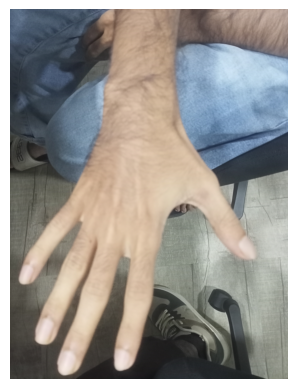

predicted: paper
tensor([[ 1.3407, -2.3158, -3.8487]])
./data_rps_test/IMG20250918173427.jpg


------------------------------------------------------




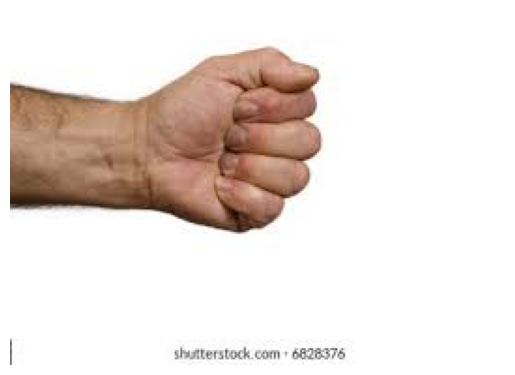

predicted: rock
tensor([[-0.3894,  1.2864, -0.4564]])
./data_rps_test/images.jpeg


------------------------------------------------------




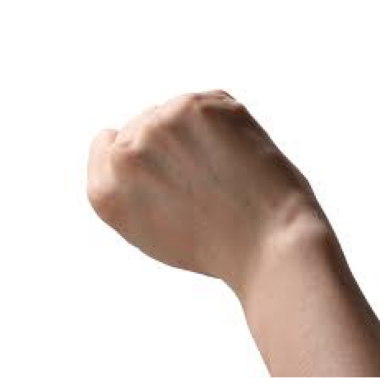

predicted: rock
tensor([[ 0.2531, 10.4437, -6.0016]])
./data_rps_test/images (3).jpeg


------------------------------------------------------




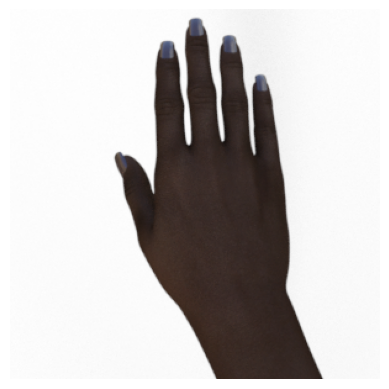

predicted: paper
tensor([[ 2.6015, -4.2667, -6.9305]])
./data_rps_test/paper8.png


------------------------------------------------------




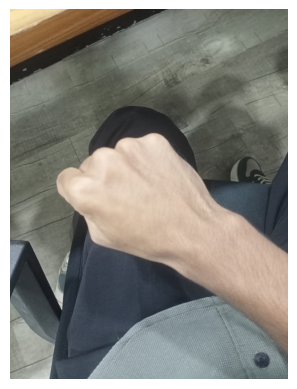

predicted: scissors
tensor([[-0.3682, -0.1240,  1.0768]])
./data_rps_test/IMG20250918173410.jpg


------------------------------------------------------




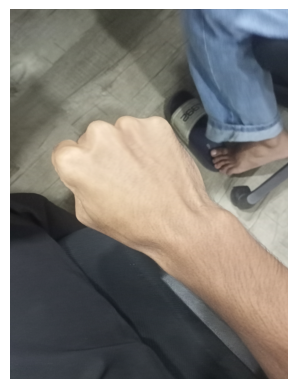

predicted: rock
tensor([[-0.5743,  0.3545,  0.3392]])
./data_rps_test/IMG20250918173407.jpg


------------------------------------------------------




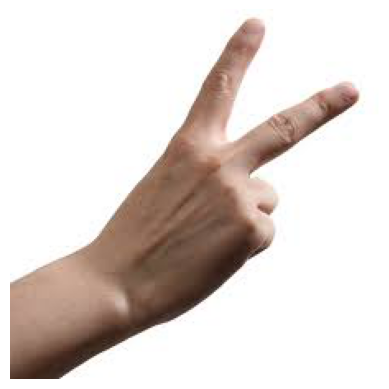

predicted: scissors
tensor([[ 1.4483e-03, -1.2027e+00,  2.8714e+00]])
./data_rps_test/images (1).jpeg


------------------------------------------------------




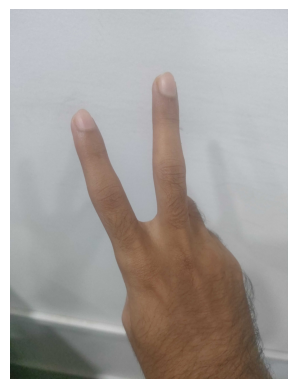

predicted: scissors
tensor([[-0.0141, -1.2791,  3.2482]])
./data_rps_test/IMG_20250918_104236.jpg


------------------------------------------------------




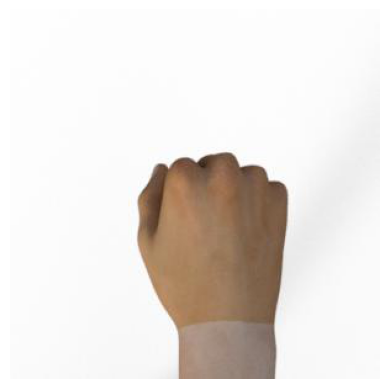

predicted: rock
tensor([[ 0.1047,  8.3123, -4.7128]])
./data_rps_test/original.jpg


------------------------------------------------------




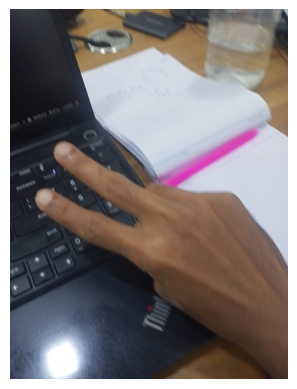

predicted: scissors
tensor([[ 0.2514, -1.9583,  4.2508]])
./data_rps_test/IMG20250918120958.jpg


------------------------------------------------------




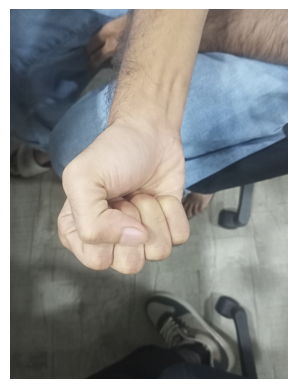

predicted: rock
tensor([[-0.5743,  0.3545,  0.3392]])
./data_rps_test/IMG20250918173433.jpg


------------------------------------------------------




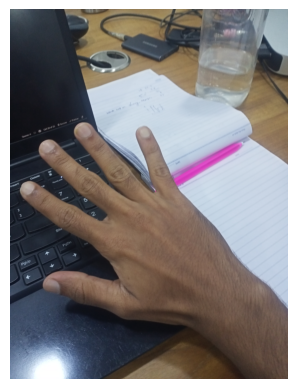

predicted: paper
tensor([[ 0.1634, -0.7873, -0.6465]])
./data_rps_test/IMG20250918120948.jpg


------------------------------------------------------




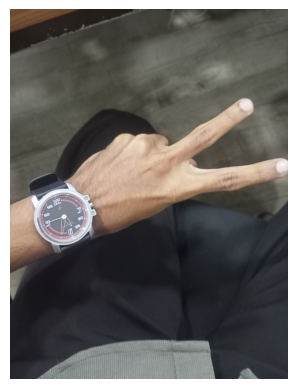

predicted: scissors
tensor([[ 0.1219, -0.7716,  0.1838]])
./data_rps_test/IMG20250918173417.jpg


------------------------------------------------------




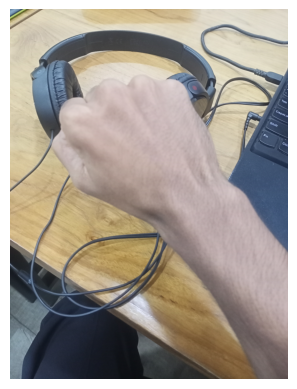

predicted: paper
tensor([[ 1.9511, -3.2736, -5.3446]])
./data_rps_test/IMG20250918173445.jpg


------------------------------------------------------




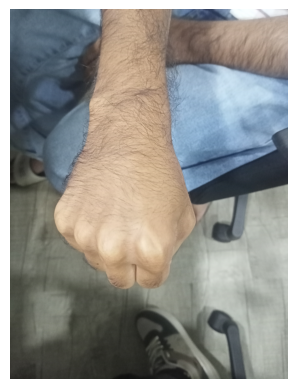

predicted: rock
tensor([[-0.5743,  0.3545,  0.3392]])
./data_rps_test/IMG20250918173437.jpg


------------------------------------------------------




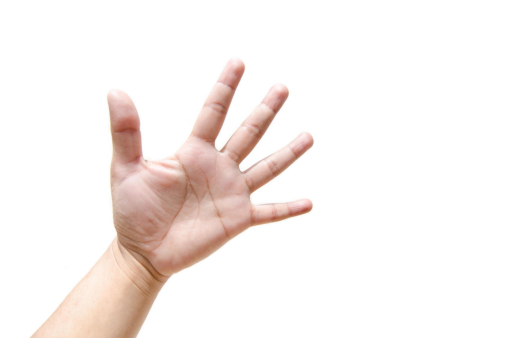

predicted: paper
tensor([[ 0.5075, -1.3161, -1.1368]])
./data_rps_test/palm.jpeg


------------------------------------------------------




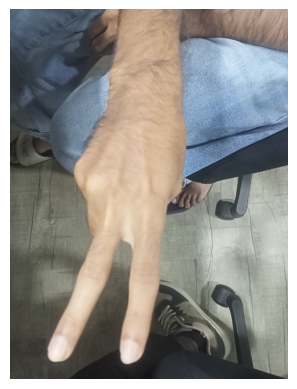

predicted: paper
tensor([[ 0.2423, -0.8470, -0.9377]])
./data_rps_test/IMG20250918173430.jpg


------------------------------------------------------




In [541]:
load_model.eval()
with torch.no_grad():

    for i in os.listdir("./data_rps_test///"):
        image_path = "./data_rps_test/" + i
        img = Image.open(image_path)

        plt.imshow(img)
        plt.axis("off")
        plt.show()

        image = load_image(image_path)

        output = load_model(image)
        _, predicted = torch.max(output, 1)
        print(f"predicted: {class_names[predicted.item()]}")

        print(output)

        print(image_path)

        img_to_show = image.squeeze(0).squeeze(0)

        print("\n\n------------------------------------------------------\n\n")